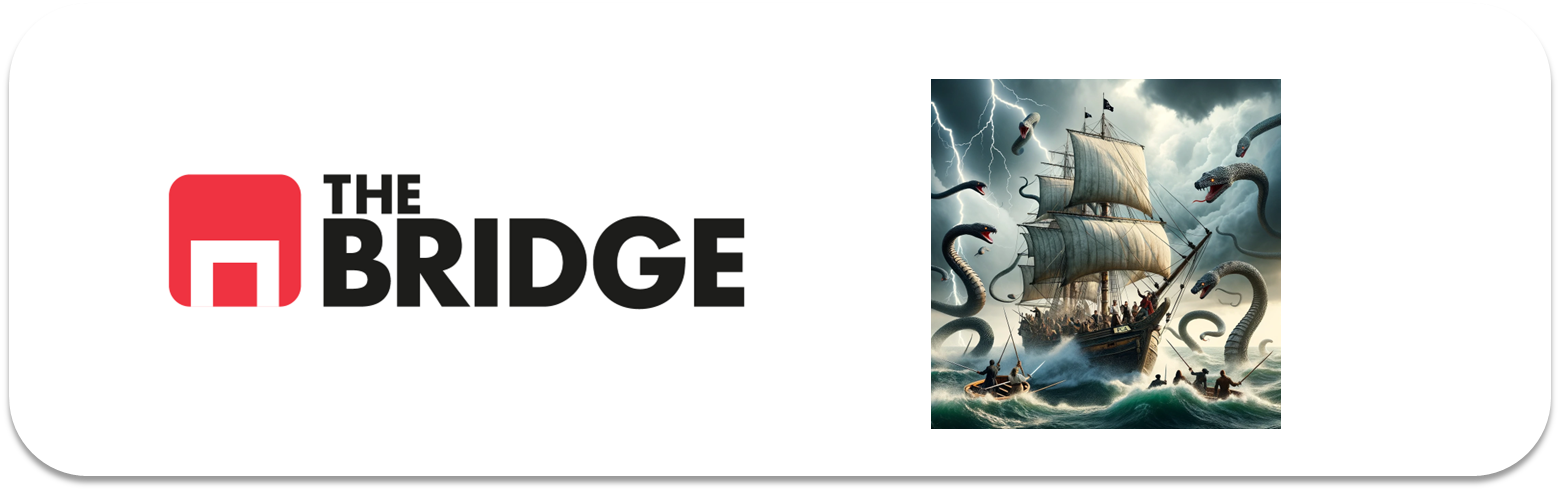

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import sys
sys.path.append("..")
from Ejercicios_Workout import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.metrics import mutual_info_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 6) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [2]:
df= pd.read_csv("data\credit_npo.csv")
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,0,0.290216,5140.0,6,0,1,0,0.0
12533,0,0.036726,62,0,0.884985,5833.0,12,0,1,0,0.0
12534,0,0.120313,49,0,0.577676,6333.0,7,0,2,0,2.0
12535,0,0.252566,63,0,0.037640,14000.0,9,0,0,0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [4]:
df["NumberOfTime30-59DaysPastDueNotWorse"].value_counts()

NumberOfTime30-59DaysPastDueNotWorse
0     10500
1      1377
2       401
3       128
4        64
5        23
98       21
6        20
8         2
7         1
Name: count, dtype: int64

In [5]:
df["NumberOfTime60-89DaysPastDueNotWorse"].value_counts()

NumberOfTime60-89DaysPastDueNotWorse
0     11901
1       492
2        86
98       21
3        18
4        14
5         4
11        1
Name: count, dtype: int64

In [6]:
df["NumberOfTimes90DaysLate"].value_counts()

NumberOfTimes90DaysLate
0     11839
1       412
2       147
3        55
4        33
98       21
5        14
6         6
7         4
8         3
10        1
9         1
13        1
Name: count, dtype: int64

In [7]:
df["NumberOfTime30-59DaysPastDueNotWorse"] = np.where(df["NumberOfTime30-59DaysPastDueNotWorse"] == 0, 0,1)

In [8]:
df["NumberOfTime60-89DaysPastDueNotWorse"] = np.where(df["NumberOfTime60-89DaysPastDueNotWorse"] == 0, 0,1)

In [9]:
df["NumberOfTimes90DaysLate"] = np.where(df["NumberOfTimes90DaysLate"] == 0, 0,1)

In [10]:
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,0,0.290216,5140.0,6,0,1,0,0.0
12533,0,0.036726,62,0,0.884985,5833.0,12,0,1,0,0.0
12534,0,0.120313,49,0,0.577676,6333.0,7,0,2,0,2.0
12535,0,0.252566,63,0,0.037640,14000.0,9,0,0,0,1.0


In [11]:
target = "SeriousDlqin2yrs"

<Axes: xlabel='SeriousDlqin2yrs', ylabel='percent'>

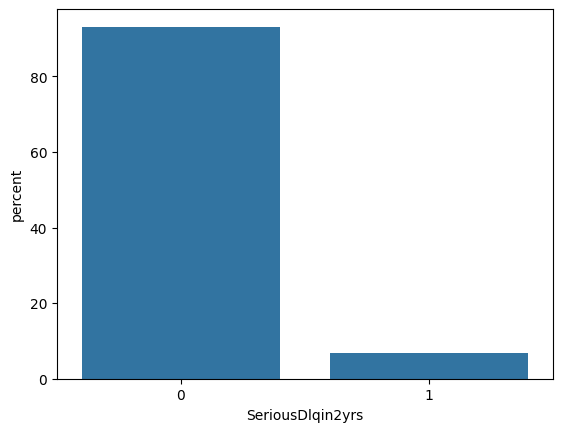

In [12]:
sns.countplot(df, x= target, stat = "percent")

- Las columnas que tienen "NumberOf.." la pase a categorica, 0 para los pacientes que no hay impagado nunca y 1 para los que hayan impagado alguna vez sin importar el numero de días. 
- El target está muy desbalanceado
- Todas las varibles son númericas
- Hay variables con nulos "MonthlyIncome" y "NumberOfDependents"
- Voy a dividir en Train y Test y hacer el mini EDA

In [13]:
train_set,test_set= train_test_split(df, test_size= 0.2, stratify= df[target], random_state= 73)

In [14]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10029 entries, 7665 to 2679
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      10029 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  10029 non-null  float64
 2   age                                   10029 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  10029 non-null  int32  
 4   DebtRatio                             10029 non-null  float64
 5   MonthlyIncome                         9455 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans       10029 non-null  int64  
 7   NumberOfTimes90DaysLate               10029 non-null  int32  
 8   NumberRealEstateLoansOrLines          10029 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  10029 non-null  int32  
 10  NumberOfDependents                    9896 non-null   float64
dtypes: float64(4), int

In [15]:
train_set["MonthlyIncome"].describe()

count      9455.000000
mean       6924.005500
std       12869.363598
min           0.000000
25%        3500.000000
50%        5416.000000
75%        8302.000000
max      702500.000000
Name: MonthlyIncome, dtype: float64

In [16]:
mediana = train_set["MonthlyIncome"].quantile(0.5)
train_set["MonthlyIncome"] = train_set["MonthlyIncome"].fillna(mediana)
test_set["MonthlyIncome"] = test_set["MonthlyIncome"].fillna(mediana)

In [17]:
train_set["NumberOfDependents"].describe()

count    9896.000000
mean        0.815784
std         1.131173
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        10.000000
Name: NumberOfDependents, dtype: float64

In [18]:
moda_train = train_set["NumberOfDependents"].mode()[0]
train_set["NumberOfDependents"] = train_set["NumberOfDependents"].fillna(moda_train)
test_set["NumberOfDependents"] = test_set["NumberOfDependents"].fillna(moda_train)

In [19]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10029 entries, 7665 to 2679
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      10029 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  10029 non-null  float64
 2   age                                   10029 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  10029 non-null  int32  
 4   DebtRatio                             10029 non-null  float64
 5   MonthlyIncome                         10029 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       10029 non-null  int64  
 7   NumberOfTimes90DaysLate               10029 non-null  int32  
 8   NumberRealEstateLoansOrLines          10029 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  10029 non-null  int32  
 10  NumberOfDependents                    10029 non-null  float64
dtypes: float64(4), int

In [20]:
features_cat = ["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfDependents"]
features_num = []
for col in train_set.columns:
    if not col in features_cat and col != target:
        features_num.append(col)

In [21]:
features_num

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberRealEstateLoansOrLines']

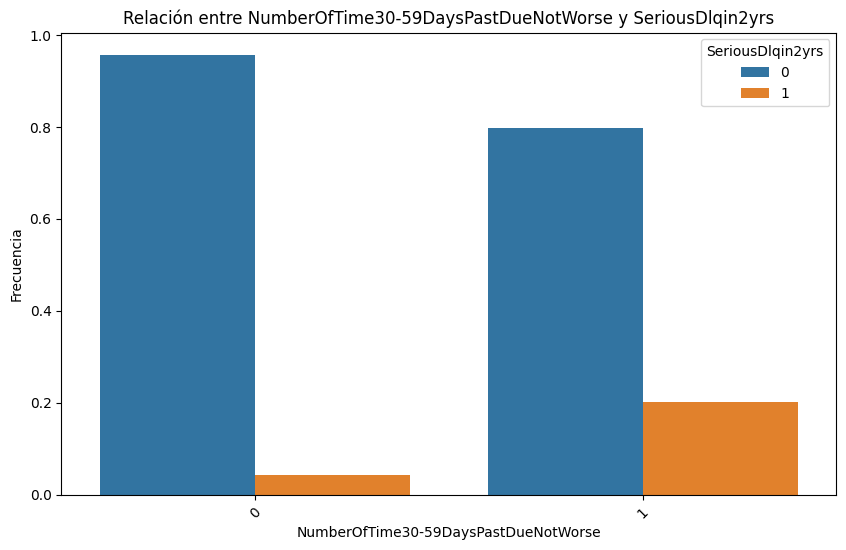

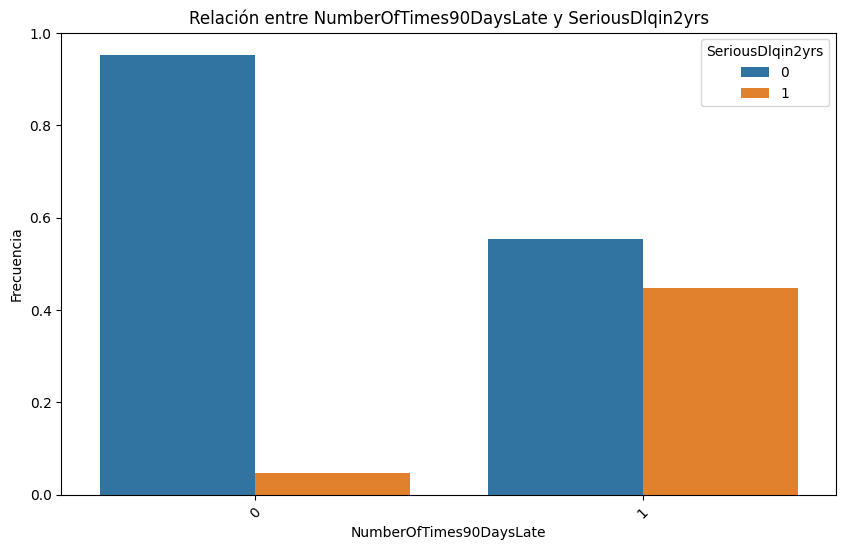

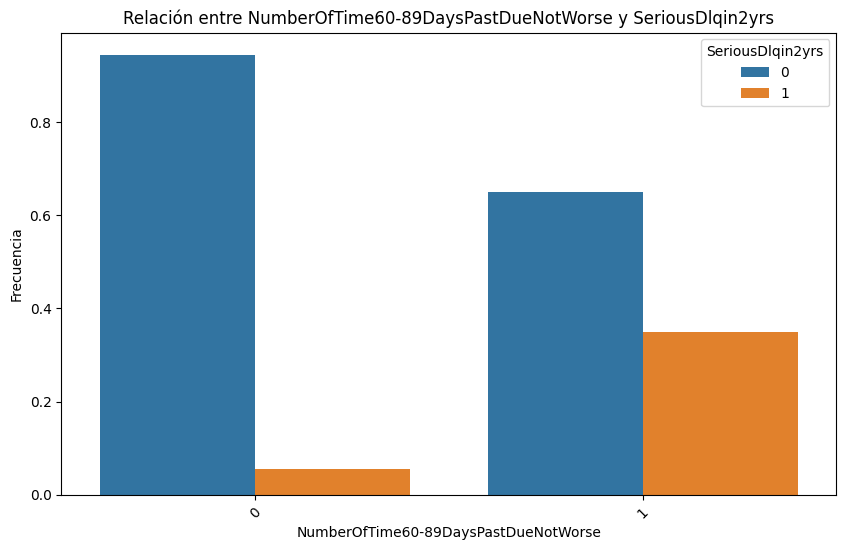

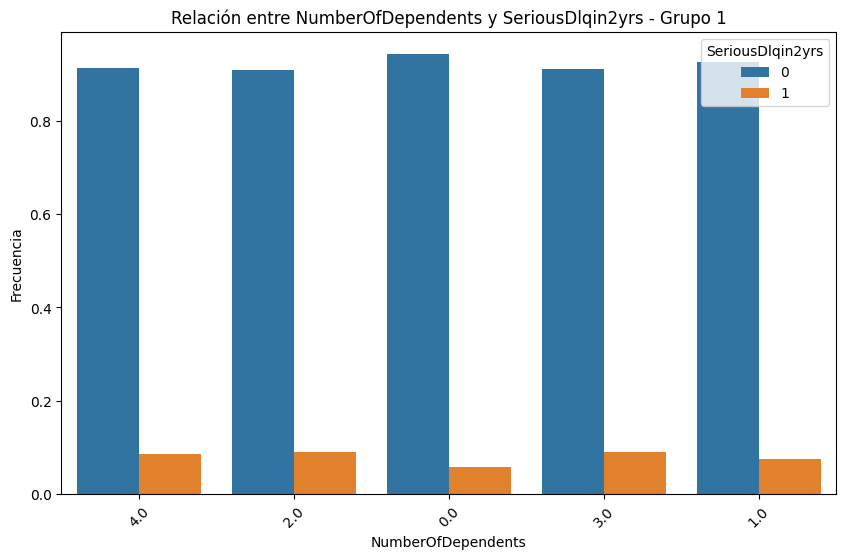

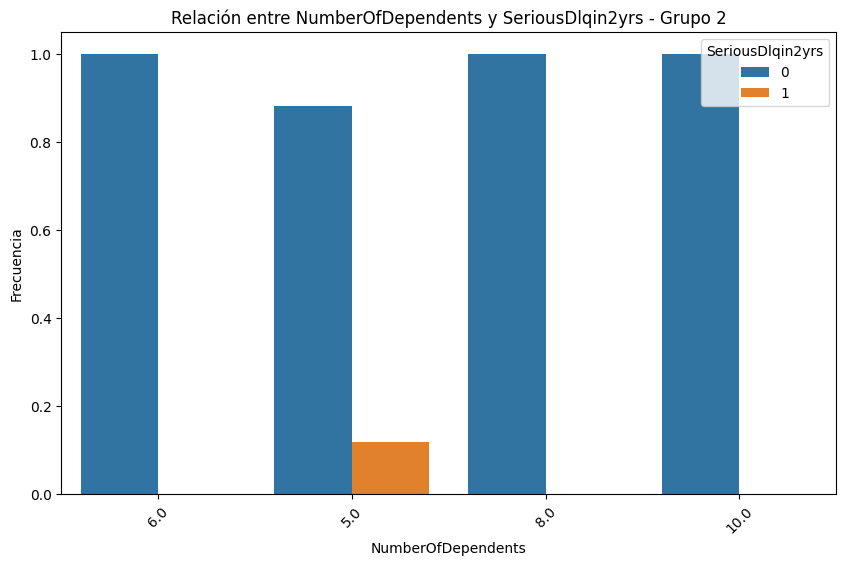

In [22]:
for col in features_cat:
    bt.plot_categorical_relationship_fin(train_set, col, target, relative_freq= True)

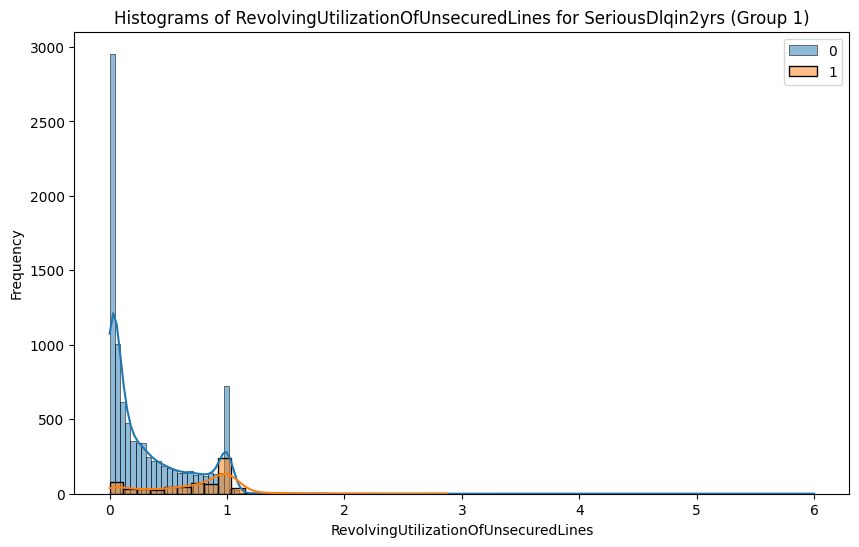

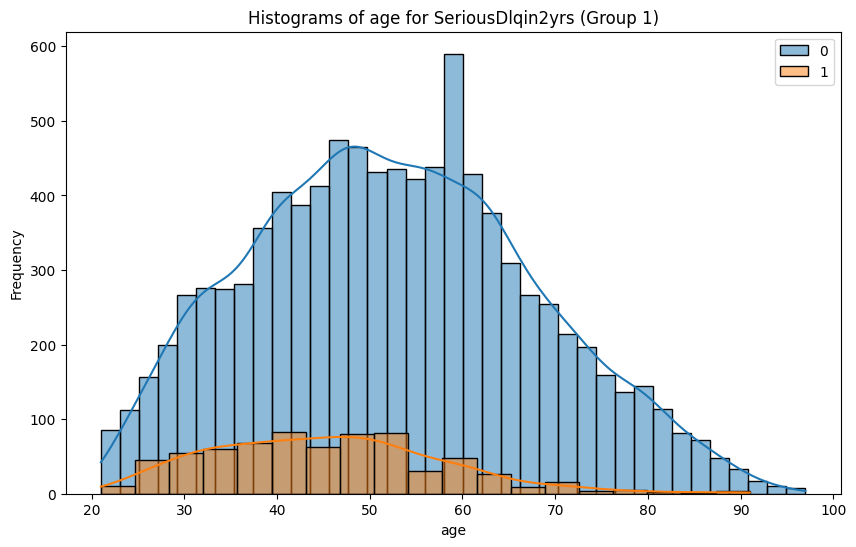

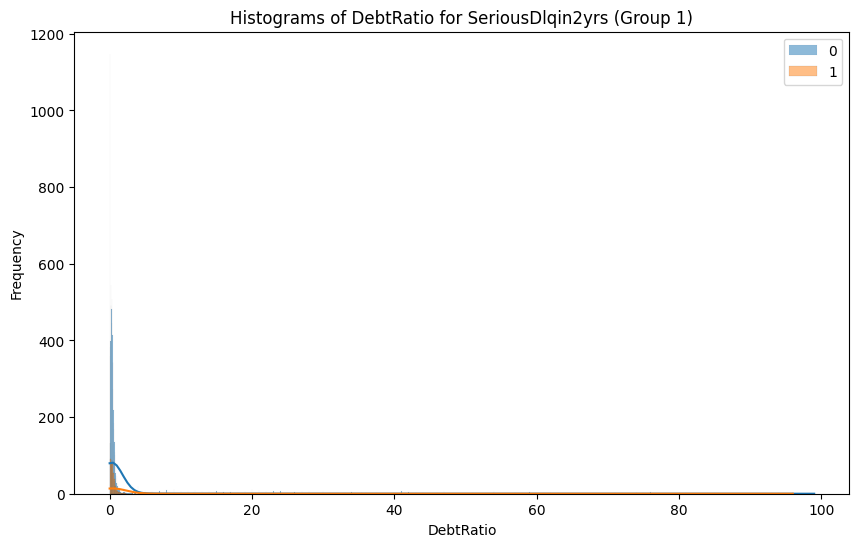

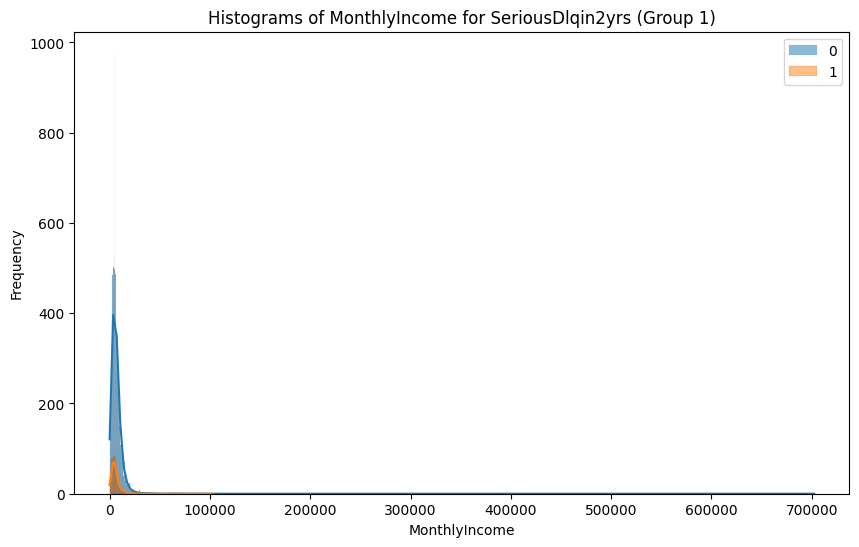

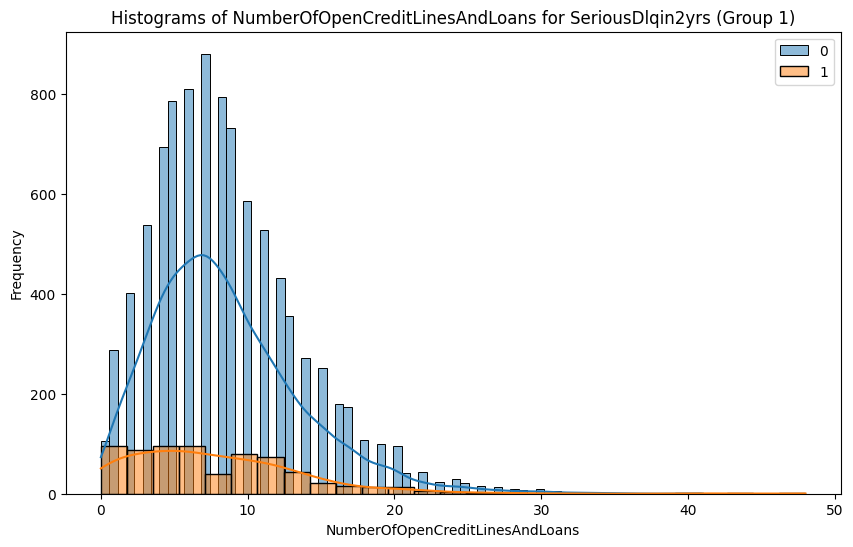

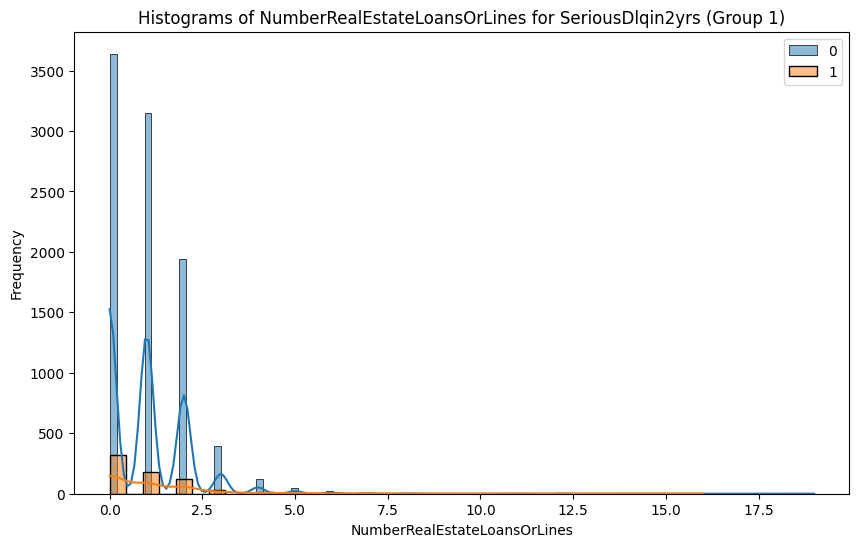

In [23]:
for col in features_num:
    bt.plot_grouped_histograms(train_set, cat_col= target, num_col= col, group_size= 2)

In [24]:
corr = train_set.corr(numeric_only = True)

In [25]:
corr[target].sort_values(ascending = False)

SeriousDlqin2yrs                        1.000000
NumberOfTimes90DaysLate                 0.360289
RevolvingUtilizationOfUnsecuredLines    0.292018
NumberOfTime60-89DaysPastDueNotWorse    0.254207
NumberOfTime30-59DaysPastDueNotWorse    0.231635
NumberOfDependents                      0.047755
NumberRealEstateLoansOrLines            0.006743
DebtRatio                              -0.018165
MonthlyIncome                          -0.018698
NumberOfOpenCreditLinesAndLoans        -0.037867
age                                    -0.120227
Name: SeriousDlqin2yrs, dtype: float64

In [26]:
np.abs(corr[target]).sort_values(ascending = False)

SeriousDlqin2yrs                        1.000000
NumberOfTimes90DaysLate                 0.360289
RevolvingUtilizationOfUnsecuredLines    0.292018
NumberOfTime60-89DaysPastDueNotWorse    0.254207
NumberOfTime30-59DaysPastDueNotWorse    0.231635
age                                     0.120227
NumberOfDependents                      0.047755
NumberOfOpenCreditLinesAndLoans         0.037867
MonthlyIncome                           0.018698
DebtRatio                               0.018165
NumberRealEstateLoansOrLines            0.006743
Name: SeriousDlqin2yrs, dtype: float64

<Axes: >

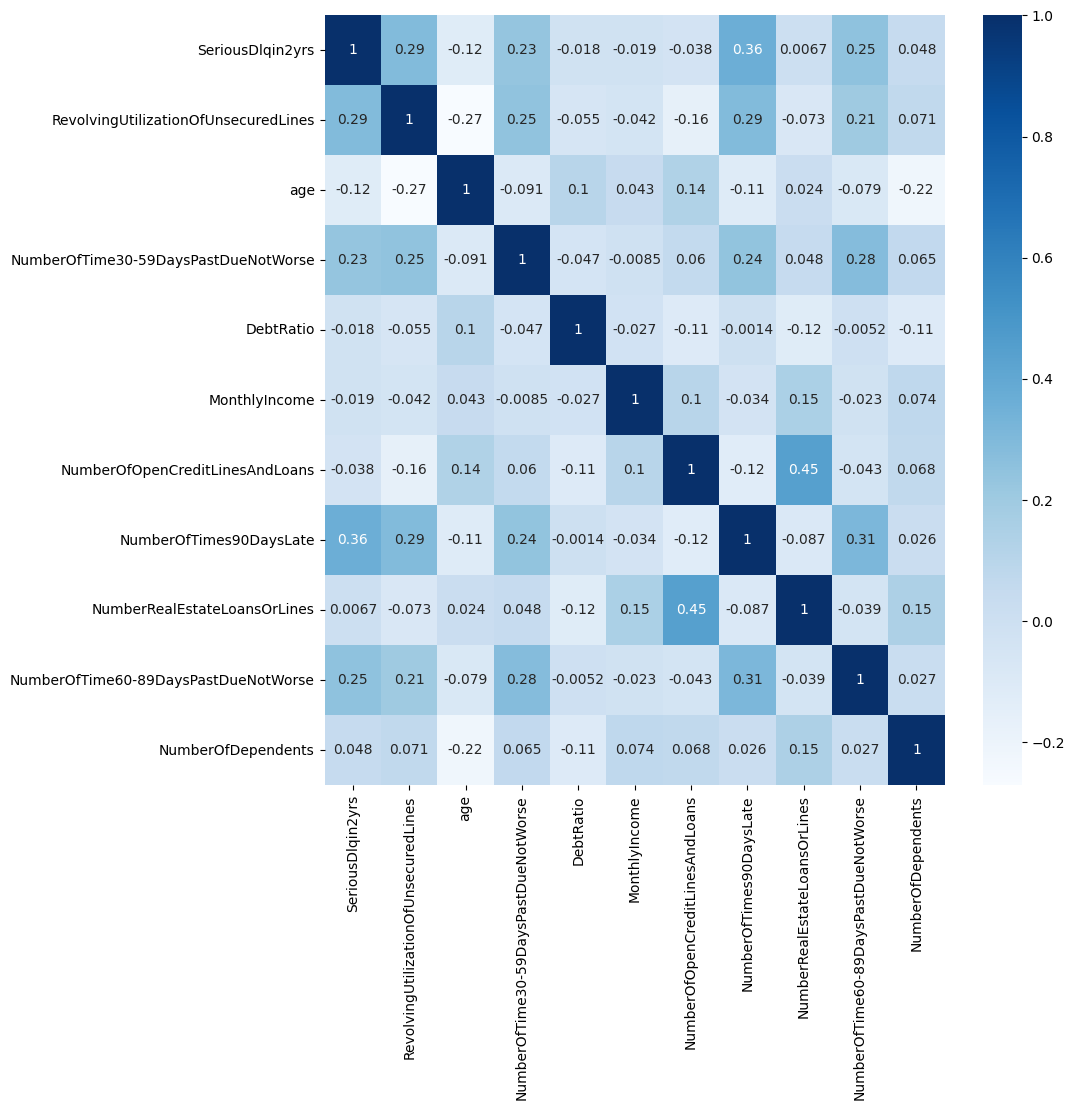

In [27]:
plt.figure(figsize = (10,10))
sns.heatmap(corr, annot = True, cmap = "Blues")

In [28]:
serie_corr = np.abs(corr[target]).sort_values(ascending = False)

In [29]:
r_minimo = 0.15
features_sel = serie_corr[serie_corr >= r_minimo].index.to_list()
features_sel.remove(target)

In [30]:
criterio_col = 0.7
excluidas = []
for col in features_num:
    print(f"Voy a comprobar la colinealidad con {col}")
    if col not in excluidas:
        for col_2,valor_corr in corr[col].items():
            print(f"Comprobando con {col_2}")
            if col != col_2 and col_2 in features_num:
                if np.abs(valor_corr) >= criterio_col:
                    print(f"Correlo al {valor_corr}, por eso excluyo a {col_2}")
                    excluidas.append(col_2)
                else:
                    print(f"Conmigo no tiene problema, dejo a {col_2} tranquila")
            elif col == col_2:
                print("soy yo misma, no me excluyo")
            else:
                print("No estaba ya en la lista original, no hago nada")
excluidas = list(set(excluidas))

Voy a comprobar la colinealidad con RevolvingUtilizationOfUnsecuredLines
Comprobando con SeriousDlqin2yrs
No estaba ya en la lista original, no hago nada
Comprobando con RevolvingUtilizationOfUnsecuredLines
soy yo misma, no me excluyo
Comprobando con age
Conmigo no tiene problema, dejo a age tranquila
Comprobando con NumberOfTime30-59DaysPastDueNotWorse
No estaba ya en la lista original, no hago nada
Comprobando con DebtRatio
Conmigo no tiene problema, dejo a DebtRatio tranquila
Comprobando con MonthlyIncome
Conmigo no tiene problema, dejo a MonthlyIncome tranquila
Comprobando con NumberOfOpenCreditLinesAndLoans
Conmigo no tiene problema, dejo a NumberOfOpenCreditLinesAndLoans tranquila
Comprobando con NumberOfTimes90DaysLate
No estaba ya en la lista original, no hago nada
Comprobando con NumberRealEstateLoansOrLines
Conmigo no tiene problema, dejo a NumberRealEstateLoansOrLines tranquila
Comprobando con NumberOfTime60-89DaysPastDueNotWorse
No estaba ya en la lista original, no hago na

In [31]:
excluidas

[]

- Después de hacer el análisis visual, correlación y covarianza me quedo con las features 'RevolvingUtilizationOfUnsecuredLines','NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse' que están en la lista features_num_sel

In [32]:
for col in features_cat:
    print(f"MI({col};{target}):", mutual_info_score(train_set[col],train_set[target]))

MI(NumberOfTime30-59DaysPastDueNotWorse;SeriousDlqin2yrs): 0.020325913295113296
MI(NumberOfTimes90DaysLate;SeriousDlqin2yrs): 0.034159309554561174
MI(NumberOfTime60-89DaysPastDueNotWorse;SeriousDlqin2yrs): 0.01848097378015673
MI(NumberOfDependents;SeriousDlqin2yrs): 0.001615256719863842


- El mutual information nos indica que la relación entre el target y las features categoricas no tienen dependencia entre ellas.

In [33]:
features_anova = []
target_cat = train_set[target].unique()  
for feat in features_num:
    print(feat)
    features_num_por_target = [train_set[train_set[target] == categoria][feat] for categoria in target_cat]
    f_val, p_val = stats.f_oneway(*features_num_por_target)                                               
    print("Valor F:", f_val)
    print("Valor p:", p_val)
    if p_val < 0.05:
        features_anova.append(feat)

RevolvingUtilizationOfUnsecuredLines
Valor F: 934.7575810330258
Valor p: 2.328116366984015e-196
age
Valor F: 147.06119780220988
Valor p: 1.3074331539454503e-33
DebtRatio
Valor F: 3.30975785254545
Valor p: 0.06889944933596162
MonthlyIncome
Valor F: 3.506653995757633
Valor p: 0.06115186158587252
NumberOfOpenCreditLinesAndLoans
Valor F: 14.398479010141843
Valor p: 0.0001487919527445117
NumberRealEstateLoansOrLines
Valor F: 0.45595390512988365
Valor p: 0.4995365873095191


In [34]:
features_anova

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfOpenCreditLinesAndLoans']

In [35]:
X_train = train_set.drop(columns= target)
y_train = train_set[target]
X_test = train_set.drop(columns= target)
y_test= train_set[target]

In [36]:
selector = SelectKBest(f_classif, k=5)
x_data_kbest = selector.fit_transform(X_train, y_train)
X_train_kbest = pd.DataFrame(x_data_kbest, columns = selector.get_feature_names_out())
X_train_kbest

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse
0,0.118344,52.0,0.0,0.0,0.0
1,0.319803,42.0,0.0,0.0,0.0
2,0.944616,57.0,1.0,0.0,0.0
3,0.004553,49.0,0.0,0.0,0.0
4,0.257532,39.0,0.0,0.0,0.0
...,...,...,...,...,...
10024,0.301187,59.0,0.0,0.0,0.0
10025,0.059570,46.0,0.0,0.0,0.0
10026,0.149178,40.0,0.0,0.0,0.0
10027,0.054508,55.0,0.0,0.0,0.0


In [37]:
selectKBest = selector.get_feature_names_out()
selectKBest

array(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
       'NumberOfTime60-89DaysPastDueNotWorse'], dtype=object)

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf_selector = RandomForestClassifier(random_state= 73)


In [39]:
rf_selector.fit(X_train,y_train)

RandomForestClassifier(random_state=73)

In [40]:
selector_model = SelectFromModel(estimator = rf_selector, threshold= "median")

In [41]:
selector_model.fit(X_train, y_train) 

SelectFromModel(estimator=RandomForestClassifier(random_state=73),
                threshold='median')

In [42]:
features_sle_model= selector_model.get_feature_names_out()
features_sle_model

array(['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans'], dtype=object)

In [43]:
rf_RFE = RandomForestClassifier(random_state= 42) 
rfe = RFE(estimator = rf_RFE,
          n_features_to_select= 5, 
          step = 1) 

rfe.fit(X_train, y_train)
print(rfe.ranking_)


[1 1 6 1 1 1 2 4 5 3]


In [44]:
pd.DataFrame(rfe.ranking_, columns= ["ranking"], index = X_train.columns).sort_values("ranking")

,ranking
RevolvingUtilizationOfUnsecuredLines,1
age,1
DebtRatio,1
MonthlyIncome,1
NumberOfOpenCreditLinesAndLoans,1
NumberOfTimes90DaysLate,2
NumberOfDependents,3
NumberRealEstateLoansOrLines,4
NumberOfTime60-89DaysPastDueNotWorse,5
NumberOfTime30-59DaysPastDueNotWorse,6


In [45]:
features_rfe = list(selector_model.get_feature_names_out())
features_rfe

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans']

In [46]:
rf_SFS = RandomForestClassifier(random_state = 42)

sfs_forward = SequentialFeatureSelector(rf_SFS,
                                        n_features_to_select = 5,
                                        cv = 4,
                                        scoring = "balanced_accuracy")


sfs_forward.fit(X_train, y_train)

SequentialFeatureSelector(cv=4,
                          estimator=RandomForestClassifier(random_state=42),
                          n_features_to_select=5, scoring='balanced_accuracy')

In [47]:
features_sfs = sfs_forward.get_feature_names_out()
features_sfs

array(['RevolvingUtilizationOfUnsecuredLines',
       'NumberOfTime30-59DaysPastDueNotWorse',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberOfTime60-89DaysPastDueNotWorse'], dtype=object)

In [48]:
#Lista creadas:
print(features_sel)
print("*************************************")
print(selectKBest)
print("*************************************")
print(features_sle_model)
print("*************************************")
print(features_rfe)
print("*************************************")
print(features_sfs)

['NumberOfTimes90DaysLate', 'RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse']
*************************************
['RevolvingUtilizationOfUnsecuredLines' 'age'
 'NumberOfTime30-59DaysPastDueNotWorse' 'NumberOfTimes90DaysLate'
 'NumberOfTime60-89DaysPastDueNotWorse']
*************************************
['RevolvingUtilizationOfUnsecuredLines' 'age' 'DebtRatio' 'MonthlyIncome'
 'NumberOfOpenCreditLinesAndLoans']
*************************************
['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans']
*************************************
['RevolvingUtilizationOfUnsecuredLines'
 'NumberOfTime30-59DaysPastDueNotWorse' 'NumberOfOpenCreditLinesAndLoans'
 'NumberOfTimes90DaysLate' 'NumberOfTime60-89DaysPastDueNotWorse']


In [49]:
X_train[features_sel]

,NumberOfTimes90DaysLate,RevolvingUtilizationOfUnsecuredLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse
7665,0,0.118344,0,0
2482,0,0.319803,0,0
995,0,0.944616,0,1
3720,0,0.004553,0,0
2910,0,0.257532,0,0
...,...,...,...,...
8968,0,0.301187,0,0
10215,0,0.059570,0,0
4364,0,0.149178,0,0
8147,0,0.054508,0,0


In [50]:
X_train[selectKBest]

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse
7665,0.118344,52,0,0,0
2482,0.319803,42,0,0,0
995,0.944616,57,1,0,0
3720,0.004553,49,0,0,0
2910,0.257532,39,0,0,0
...,...,...,...,...,...
8968,0.301187,59,0,0,0
10215,0.059570,46,0,0,0
4364,0.149178,40,0,0,0
8147,0.054508,55,0,0,0


In [51]:
rf_clf = RandomForestClassifier(random_state=73)

features_sets = [features_sel,
                selectKBest,
                features_sle_model,
                features_rfe,
                features_sfs]


predictions = []
for features in features_sets:
    X_subset = X_train[features]
   
    scores = cross_val_score(rf_clf, X_subset, y_train, cv=5, scoring='balanced_accuracy')
    avg_score = np.mean(scores)
    print("Balanced_accuracy:", avg_score)


hard_voting = np.sum(predictions, axis=0) >= (len(predictions) / 2)


features_hard_voting = features_sets[np.argmax(hard_voting)]

print("Características seleccionadas:", features_hard_voting)

Balanced_accuracy: 0.6076977242832742
Balanced_accuracy: 0.5927342719281251
Balanced_accuracy: 0.5288476272417817
Balanced_accuracy: 0.5288476272417817
Balanced_accuracy: 0.5988988512848648
Características seleccionadas: ['NumberOfTimes90DaysLate', 'RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse']


In [52]:
model_names = ["Random Forest","XGBoost","LightGBM"]
rf_clf = RandomForestClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42)
lgb_clf = LGBMClassifier(random_state=42, verbose=-100)
model_set = [rf_clf, xgb_clf, lgb_clf]

features_sets = {'features_sel':features_sel,
                 'selectKBest':selectKBest,
                 'features_sle_model':features_sle_model,
                 'features_rfe':features_rfe,
                 'features_sfs':features_sfs, 
                }

best_score = 0
best_model = None
best_features = None

for feature_name, feature in features_sets.items():
    for model_name, model in zip(model_names, model_set):
        scores = cross_val_score(model, X_train[feature], y_train, cv=3, scoring="balanced_accuracy")
        mean_score = np.mean(scores)
        print(f"Mean score for {model_name} using {feature_name}: {mean_score}")
        if mean_score > best_score:
            best_score = mean_score
            best_model = model_name
            best_features = feature_name

print(f"Best model: {best_model} with features: {best_features} and mean score: {best_score}")

Mean score for Random Forest using features_sel: 0.6026550112585328
Mean score for XGBoost using features_sel: 0.5792122801835722
Mean score for LightGBM using features_sel: 0.5895554557653773
Mean score for Random Forest using selectKBest: 0.5933632599333215
Mean score for XGBoost using selectKBest: 0.5885980970854555
Mean score for LightGBM using selectKBest: 0.585425231196708
Mean score for Random Forest using features_sle_model: 0.5291130530434988
Mean score for XGBoost using features_sle_model: 0.5344071411507602
Mean score for LightGBM using features_sle_model: 0.5271407134445251
Mean score for Random Forest using features_rfe: 0.5291130530434988
Mean score for XGBoost using features_rfe: 0.5344071411507602
Mean score for LightGBM using features_rfe: 0.5271407134445251
Mean score for Random Forest using features_sfs: 0.5986719102816509
Mean score for XGBoost using features_sfs: 0.5906774465189183
Mean score for LightGBM using features_sfs: 0.5936925203761739
Best model: Random Fo

In [53]:
param_grid = {"n_estimators": [100,200],
    "max_depth": [5,10,15],
    "min_samples_leaf": [2,5,10],
    "max_features": ["sqrt","log2",None],
    "class_weight": ["balanced", None]
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid= param_grid,
                       cv = 5,
                       scoring = "balanced_accuracy",
                       n_jobs = -1)

rf_grid.fit(X_train[features_sel], y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='balanced_accuracy')

In [54]:
y_pred = rf_grid.predict(X_test[features_sel])
print(balanced_accuracy_score(y_test, y_pred))

0.7798387089275292


In [55]:
print(classification_report(y_test, rf_grid.best_estimator_.predict(X_test[features_sel])))

              precision    recall  f1-score   support

           0       0.98      0.74      0.85      9338
           1       0.19      0.82      0.31       691

    accuracy                           0.75     10029
   macro avg       0.59      0.78      0.58     10029
weighted avg       0.93      0.75      0.81     10029



### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.